## Instalacion de Paquetes y dependencia 

In [8]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install lxml
!pip install pymysql
!pip install python-dotenv
!pip install sqlalchemy
!pip install xlrd


In [9]:
#librerias para analizar datos
import os
import numpy as np
import pandas as pd
from datetime import datetime
#librerias de graficos
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from sqlalchemy import create_engine, MetaData, Table, select

pd.set_option('display.max_colwidth', None)
pd.set_option('float_format', '{:,.2f}'.format)

In [10]:
try: 
    customer_r = pd.read_xml('data/Customer_R.xml')
    customer_r.head(2)
except FileNotFoundError:
    print('File not found')
except pd.errors.EmptyDataError:
    print('Empty Data')
except Exception as e:
    print(f'Expecion general ', e)

In [11]:
try: 
    customer_w = pd.read_xml('data/Customer_W.xml')
    customer_w.head(2)
except FileNotFoundError:
    print('File not found')
except pd.errors.EmptyDataError:
    print('Empty Data')
except Exception as e:
    print(f'Expecion general ', e)

In [12]:
products = pd.read_csv('data/Products.txt', delimiter='|', names=['product_id', 'detail', 'package'])
products.head(2)

,product_id,detail,package
0,1,Kool Cola,1 Liter
1,2,Kool Cola,2 Liter


# Configurar la conexión con SQLAlchemy utilizando pymysql y las variables de entorno

In [13]:
load_dotenv()
DATABASE_URL = f"mysql+pymysql://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
engine = create_engine(DATABASE_URL)

metadata = MetaData()
billing = Table('billing', metadata, autoload_with=engine)
billing_detail = Table('billing_detail', metadata, autoload_with=engine)
prices = Table('prices', metadata, autoload_with=engine, schema='sales')

def query_sales_after_2008():
    with engine.connect() as connection:
        # Usar el constructor de consultas para generar la consulta
        query = select(
            billing.c.BILLING_ID.label('billing_id'),
            billing.c.REGION.label('region'),
            billing.c.BRANCH_ID.label('branch_id'),
            billing.c.DATE.label('date'),
            billing.c.CUSTOMER_ID.label('customer_id'),
            billing.c.EMPLOYEE_ID.label('employee_id'),
            billing_detail.c.PRODUCT_ID.label('product_id'),
            billing_detail.c.QUANTITY.label('quantity')
        ).select_from(
            billing.join(billing_detail, billing.c.BILLING_ID == billing_detail.c.BILLING_ID)
        )
        df = pd.read_sql(query, connection)
        return df

def query_sales_prices():
    with engine.connect() as connection:
        # Construir la consulta utilizando el constructor de consultas
        query = select(
            billing.c.BILLING_ID.label('billing_id'),
            billing.c.REGION.label('region'),
            billing.c.BRANCH_ID.label('branch_id'),
            billing.c.DATE.label('date'),
            billing.c.CUSTOMER_ID.label('customer_id'),
            billing.c.EMPLOYEE_ID.label('employee_id'),
            billing_detail.c.PRODUCT_ID.label('product_id'),
            billing_detail.c.QUANTITY.label('quantity'),
            prices.c.DATE.label('date_price'),
            prices.c.PRICE.label('price')
        ).select_from(
            billing.join(billing_detail, billing.c.BILLING_ID == billing_detail.c.BILLING_ID)
                  .join(prices, billing_detail.c.PRODUCT_ID == prices.c.PRODUCT_ID)
        )

        # Ejecutar la consulta y cargar los resultados en un DataFrame de pandas
        df = pd.read_sql(query, connection)
        return df
    
history_sales_after_2008 = query_sales_after_2008()
print(history_sales_after_2008.head(2))


   billing_id region  branch_id                date  customer_id  employee_id  \
0      835920  South          1 2009-01-01 00:03:48         2298          242   
1      835920  South          1 2009-01-01 00:03:48         2298          242   

   product_id  quantity  
0           2         5  
1           5        11  


# TRANSFORMACIONES

In [14]:
#Transformacion de datos de los clientes
df_wholesale = customer_w.copy() #copiamos el dataframe en una variable nueva para no tocar los datos originales
df_wholesale['customer_type'] = 'Wholesale'
df_wholesale.head(2)

,CUSTOMER_ID,FULL_NAME,BIRTH_DATE,CITY,STATE,ZIPCODE,customer_type
0,2001,"Son, Alma",08/12/1961,Millbrook,New York,24591,Wholesale
1,2002,"Brandon, Cornelius",09/04/1961,Manhattan,New York,12113,Wholesale


In [15]:
df_retail = customer_r.copy() #copiamos el dataframe en una variable nueva para no tocar los datos originales
df_retail['customer_type'] = 'Retail'
df_retail.head(2)

,CUSTOMER_ID,FULL_NAME,BIRTH_DATE,CITY,STATE,ZIPCODE,customer_type
0,1001,"Nowmer, Sheri",03/12/1960,Poughkeepsie,New York,21101,Retail
1,1002,"Whelply, Derrick",06/04/1960,Manhattan,New York,12112,Retail


In [16]:
df_customer = pd.concat([df_wholesale,df_retail]).reset_index(drop=True)
df_customer['CUSTOMER_ID'] = df_customer['CUSTOMER_ID'].astype(int)
df_customer = df_customer[['CUSTOMER_ID','FULL_NAME','customer_type']]
df_customer.head(2)

,CUSTOMER_ID,FULL_NAME,customer_type
0,2001,"Son, Alma",Wholesale
1,2002,"Brandon, Cornelius",Wholesale


In [17]:
columns = df_customer.columns.tolist()
for col in columns:
    df_customer = df_customer.rename(columns={f'{col}':f'{col.lower()}'})

df_customer.head(2)
#Fin de Transformacion de datos de los clientes

,customer_id,full_name,customer_type
0,2001,"Son, Alma",Wholesale
1,2002,"Brandon, Cornelius",Wholesale


In [18]:
#Transformacion de datos de los productos
df_products = products.copy() #copiamos los datos para no trabajar directamente con los originales
df_products['product_id'] = df_products['product_id'].astype(str).str.rstrip().astype(int)
df_products['detail'] = df_products['detail'].str.rstrip()
df_products.head(5)

,product_id,detail,package
0,1,Kool Cola,1 Liter
1,2,Kool Cola,2 Liter
2,3,Kool Cola,500 cm3 can
3,4,Diet Cola,1 Liter
4,5,Diet Cola,2 Liter


In [19]:
df_products['old_package'] = df_products['package']
df_products['package'] = np.where(df_products['package'].str.contains('can')
                                  , 'Can'
                                  , 'Bottle')
df_products.head(2)

,product_id,detail,package,old_package
0,1,Kool Cola,Bottle,1 Liter
1,2,Kool Cola,Bottle,2 Liter


In [20]:
#creamos una funcion para calcular los litros que tiene cada producto
def transform_liters(list):
    if list[1] == 'Liter':
        return float(list[0])
    elif list[1] == 'cm3':
        return float(list[0])/1000
    else:
        np.nan

#y ahora la utilizamos
df_products['splitted'] = df_products['old_package'].str.split(' ')
df_products['litter'] = df_products['splitted'].apply(lambda x: transform_liters(x))
df_products.head(2)

,product_id,detail,package,old_package,splitted,litter
0,1,Kool Cola,Bottle,1 Liter,"[1, Liter]",1.00
1,2,Kool Cola,Bottle,2 Liter,"[2, Liter]",2.00


In [21]:
#ya no necesitamos la columnas que creamos recien llamadas old_package y splitted, entonces la borramos
df_products = df_products.drop(columns = ['old_package', 'splitted'])
df_products.head(2)

#Fin Transformacion de datos de los productos

,product_id,detail,package,litter
0,1,Kool Cola,Bottle,1.00
1,2,Kool Cola,Bottle,2.00


In [22]:
#Transformacion de los datos de las ventas

df_sales = history_sales_after_2008.copy()
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales['timestamp'] = df_sales['date']
df_sales['date'] = pd.to_datetime(df_sales['date'].dt.date)
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317868 entries, 0 to 317867
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   billing_id   317868 non-null  int64         
 1   region       317868 non-null  object        
 2   branch_id    317868 non-null  int64         
 3   date         317868 non-null  datetime64[ns]
 4   customer_id  317868 non-null  int64         
 5   employee_id  317868 non-null  int64         
 6   product_id   317868 non-null  int64         
 7   quantity     317868 non-null  int64         
 8   timestamp    317868 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(6), object(1)
memory usage: 21.8+ MB


In [23]:
df_sales.head(2)

,billing_id,region,branch_id,date,customer_id,employee_id,product_id,quantity,timestamp
0,835920,South,1,2009-01-01,2298,242,2,5,2009-01-01 00:03:48
1,835920,South,1,2009-01-01,2298,242,5,11,2009-01-01 00:03:48


In [24]:
df_sales['product_id'] = df_sales['product_id'].fillna(-1).astype(int)
df_sales = df_sales[['date','billing_id','customer_id','product_id','quantity']]
df_sales.info()

#Fin Transformacion de los datos de las ventas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317868 entries, 0 to 317867
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   date         317868 non-null  datetime64[ns]
 1   billing_id   317868 non-null  int64         
 2   customer_id  317868 non-null  int64         
 3   product_id   317868 non-null  int32         
 4   quantity     317868 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(3)
memory usage: 10.9 MB


# Etapa de PRESENTACION

### En esta etapa se van a relacionar los data frames realizados anteriormente conformando un modelo de datos (Data Mart)

In [25]:
#mergeamos las ventas con los productos (ambos tienen una columna para el id del producto)
df_sales = df_sales.merge(df_products, how='inner', on='product_id')
df_sales.head(2)

,date,billing_id,customer_id,product_id,quantity,detail,package,litter
0,2009-01-01,835920,2298,2,5,Kool Cola,Bottle,2.00
1,2009-01-01,835920,2298,5,11,Diet Cola,Bottle,2.00


In [26]:
#por cada venta, multiplicamos la cantidad del producto vendido por los litros del envase, 
# con el fin de obtener una nueva columna con los litros vendidos en cada detalle de venta. 

df_sales['liters_sold'] = df_sales['litter'] * df_sales['quantity']
df_sales.head(2)

,date,billing_id,customer_id,product_id,quantity,detail,package,litter,liters_sold
0,2009-01-01,835920,2298,2,5,Kool Cola,Bottle,2.00,10.00
1,2009-01-01,835920,2298,5,11,Diet Cola,Bottle,2.00,22.00


In [27]:
sales_overtime = (df_sales
                  .groupby(['date','customer_id'])
                  [['quantity','liters_sold']].sum()
                  .reset_index()
)
sales_overtime.head(2)

,date,customer_id,quantity,liters_sold
0,2009-01-01,1004,29,31.50
1,2009-01-01,1006,24,17.85


In [28]:
dim_date = pd.DataFrame(pd.date_range(start='2000-01-01',end='2009-12-31'), columns=['date'])
dim_date['week']      = dim_date['date'].dt.to_period('W').dt.start_time
dim_date['month']     = dim_date['date'].dt.to_period('M').dt.start_time
dim_date['year']      = dim_date['date'].dt.year
dim_date['day_name']  = dim_date['date'].dt.strftime('%A')
dim_date['week_num']  = dim_date['date'].dt.weekday
dim_date['month_num'] = dim_date['date'].dt.month
dim_date['day_month'] = dim_date['date'].dt.strftime('%d-%b')

dim_date.head(2)


,date,week,month,year,day_name,week_num,month_num,day_month
0,2000-01-01,1999-12-27,2000-01-01,2000,Saturday,5,1,01-Jan
1,2000-01-02,1999-12-27,2000-01-01,2000,Sunday,6,1,02-Jan


# FIN TUTORIAL ETL
## Hasta acá abordé lo referido a los primeros 2 requerimientos

### Requerimiento 3
#### Rankear los productos por zonas geográficas a través del tiempo

In [29]:
try:
    regions = pd.read_csv('data/Regions.txt', delimiter = '|', names = ['region','state','city','id'])
    regions.head(2)
except FileNotFoundError:
    print('File not found')
except pd.errors.EmptyDataError:
    print('Empty Data')
except Exception as e:
    print(f'Expecion general ', e)

In [30]:
history_sales_after_2008.head(2)

,billing_id,region,branch_id,date,customer_id,employee_id,product_id,quantity
0,835920,South,1,2009-01-01 00:03:48,2298,242,2,5
1,835920,South,1,2009-01-01 00:03:48,2298,242,5,11


In [31]:
#copio los datos originales asi no los perjudico
df_sales_for_region = history_sales_after_2008.copy()
#convierto la columna product_id a integer
df_sales_for_region['product_id'] = df_sales_for_region['product_id'].fillna(-1).astype(int)
#mergeo con productos para obtener los litros de cada producto y asi obtener los litros vendidos en cada fila
df_sales_for_region = df_sales_for_region.merge(df_products, how='inner', on='product_id')
df_sales_for_region['liters_sold'] = df_sales_for_region['litter'] * df_sales_for_region['quantity']

#ranking con la suma de productos vendidos por region
rankingCantProductsForRegion = (df_sales_for_region
                                .groupby(['region'])
                                [['quantity']].sum()
                                .reset_index()
)
rankingCantProductsForRegion.head(4)

,region,quantity
0,East,851937
1,North,869768
2,South,1760533
3,West,873233


In [32]:
#ranking hecho con la suma de litros vendidos por region
rankingCantLittersForRegion = (df_sales_for_region
                                .groupby(['region'])
                                [['liters_sold']].sum()
                                .reset_index()
)
rankingCantLittersForRegion.head(4)

,region,liters_sold
0,East,"953,937.42"
1,North,"971,752.48"
2,South,"1,961,191.70"
3,West,"976,236.91"


### Requerimiento 4
#### El gerente de Marketing desea preparar una promoción de importantes descuentos en las bebidas tipo Energy Drink para promocionar este tipo de bebidas en los eventos deportivos a producirse en los meses de setiembre, porque piensa que coincide con una etapa de picos en el monto de ventas dentro del año. Es correcta esta afirmación?

In [33]:
sales_prices = query_sales_prices()
sales_prices.head(2)

,billing_id,region,branch_id,date,customer_id,employee_id,product_id,quantity,date_price,price
0,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2006-02-01 09:00:50,1.50
1,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2007-01-04 10:00:50,1.58


In [34]:
#copio los datos originales asi no los perjudico
df_sales_prices = sales_prices.copy()
#convierto la columna product_id a integer
df_sales_prices['product_id'] = df_sales_prices['product_id'].fillna(-1).astype(int)
#mergeo con productos para obtener los litros de cada producto y asi obtener los litros vendidos en cada fila
df_sales_prices_products = df_sales_prices.copy()
df_sales_prices_products = df_sales_prices_products.merge(df_products, how='inner', on='product_id')
df_sales_prices_products['liters_sold'] = df_sales_prices_products['litter'] * df_sales_prices_products['quantity']

In [35]:
df_sales_prices_products.head(2)

,billing_id,region,branch_id,date,customer_id,employee_id,product_id,quantity,date_price,price,detail,package,litter,liters_sold
0,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2006-02-01 09:00:50,1.50,Kool Cola,Bottle,2.00,10.00
1,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2007-01-04 10:00:50,1.58,Kool Cola,Bottle,2.00,10.00


In [36]:
# Filtrar por el tipo de bebida "Energy drink"
df_energy_drink = df_sales_prices_products[df_sales_prices_products['detail'] == 'Energy drink'].copy()

# Calcular la columna quantity_X_price
df_energy_drink.loc[:, 'quantity_X_price'] = df_energy_drink['quantity'] * df_energy_drink['price']

# Crear la columna year_month
df_energy_drink.loc[:, 'year_month'] = df_energy_drink['date'].dt.to_period('M')

# Agrupar por year_month y sumar el valor de quantity_X_price
df_energy_drink_sum = (df_energy_drink
                       .groupby(['year_month'])
                       [['quantity_X_price']].sum()
                       .reset_index())

# Mostrar los primeros 20 resultados
df_energy_drink_sum.head(20)


,year_month,quantity_X_price
0,2009-01,"248,144.85"
1,2009-02,"230,283.25"
2,2009-03,"126,818.26"
3,2009-04,"212,098.11"
4,2009-05,"191,205.63"
5,2009-06,"228,798.20"
6,2009-07,"16,363.13"
7,2009-08,"152,178.55"


In [37]:
df_tipos_bebida = (df_sales_for_region
              .groupby(df_sales_for_region['detail'])
              [['quantity']].sum()
              .reset_index()
)
df_tipos_bebida.head(2)

,detail,quantity
0,Birch Beer,310216
1,Caffeine Free Cola,309887


In [38]:

#necesito una nueva tabla para los clientes donde esten todas las columnas
#entonces voy a repetir el mismo proceso que hice antes para df_customer

df_customer_full = pd.concat([df_wholesale,df_retail]).reset_index(drop=True)
df_customer_full['CUSTOMER_ID'] = df_customer_full['CUSTOMER_ID'].astype(int)
columns = df_customer_full.columns.tolist()
for col in columns:
    df_customer_full = df_customer_full.rename(columns={f'{col}':f'{col.lower()}'})

df_sales_customer = df_sales_for_region.copy()
df_sales_customer = df_sales_customer.merge(df_customer_full, how = 'inner', on = 'customer_id')

# me aseguro que las columnas esten en el formato datetime
df_sales_customer['date'] = pd.to_datetime(df_sales_customer['date'])
df_sales_customer['birth_date'] = pd.to_datetime(df_sales_customer['birth_date'], dayfirst=True, errors='coerce')

# función para calcular la edad
def calculate_age(row):
    if pd.isnull(row['date']) or pd.isnull(row['birth_date']):
        return None
    return row['date'].year - row['birth_date'].year - ((row['date'].month, row['date'].day) < (row['birth_date'].month, row['birth_date'].day))

# aplico la función para crear la nueva columna 'age'
df_sales_customer['age'] = df_sales_customer.apply(calculate_age, axis=1)
df_sales_customer['age'] = df_sales_customer['age'].fillna(0).astype(int)

df_customer_x_tipo_bebida = (df_sales_customer
                             .groupby(['detail', 'age'])
                             [['liters_sold']].sum()
                             .reset_index()
)
df_customer_x_tipo_bebida.head(2)

,detail,age,liters_sold
0,Birch Beer,0,"227,853.00"
1,Birch Beer,28,12.00


### Requerimiento 6
#### El gerente de RRHH necesita saber si la edad y el sexo del empleado tienen relación con el monto de ventas.

In [39]:
try:
    employee = pd.read_excel('data/Employee.xls',names=['EMPLOYEE_ID','FULL_NAME','CATEGORY','EMPLOYMENT_DATE', 'BIRTH_DATE','EDUCATION_LEVEL', 'GENDER'])
    employee.head(2)
except FileNotFoundError:
    print('File not found')
except pd.errors.EmptyDataError:
    print('Empty Data')
except Exception as e:
    print(f'Expecion general ', e)

In [40]:
#copiamos los datos de employee para no tocar los originales
df_employee = employee.copy()
#paso a minuscula las columnas de la tabla
columns = df_employee.columns.tolist()
for col in columns:
    df_employee = df_employee.rename(columns={f'{col}':f'{col.lower()}'})
df_employee.head(2)

,employee_id,full_name,category,employment_date,birth_date,education_level,gender
0,1,"Nowmer, Sheri",President,2001-02-01 00:00:00,12/21/1955,Graduate Degree,F
1,2,"Whelply, Derrick",VP Country Manager,03/25/2002,05/30/1975,Graduate Degree,M


In [41]:
# Convertir las fechas de nacimiento en un formato estándar, inferido automáticamente
df_employee['birth_date'] = pd.to_datetime(df_employee['birth_date'], errors='coerce')

# Función para calcular la edad dado una fecha de nacimiento
def calculate_age(birth_date):
    if pd.isnull(birth_date):
        return 'Sin Edad'  # Puedes usar un valor por defecto para los casos donde no hay fecha
    today = datetime(2009, 12, 31)  # Asumimos que el cálculo de la edad es hasta 2009
    return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))

# Aplicar la función para crear la nueva columna 'age'
df_employee['age'] = df_employee['birth_date'].apply(calculate_age)

# Mostrar los primeros 20 registros
df_employee.head(20)


,employee_id,full_name,category,employment_date,birth_date,education_level,gender,age
0,1,"Nowmer, Sheri",President,2001-02-01 00:00:00,1955-12-21,Graduate Degree,F,54
1,2,"Whelply, Derrick",VP Country Manager,03/25/2002,1975-05-30,Graduate Degree,M,34
2,3,"Spence, Michael",VP Country Manager,11/28/2001,1970-02-12,Graduate Degree,M,39
3,4,"Gutierrez, Maya",VP Country Manager,05/18/2002,1973-08-04,Bachelors Degree,F,36
4,5,"Damstra, Roberta",VP Information Systems,07/30/2002,1966-02-04,Bachelors Degree,F,43
5,6,"Kanagaki, Rebecca",VP Human Resources,01/09/2004,1969-09-20,Bachelors Degree,F,40
6,7,"Brunner, Kim",Store Manager,04/28/2002,1968-02-14,Bachelors Degree,F,41
7,8,"Blumberg, Brenda",Store Manager,12/16/2001,1979-11-10,Graduate Degree,F,30
8,9,"Stanz, Darren",VP Finance,10/05/2004,1950-07-12,Partial College,M,59
9,10,"Murraiin, Jonathan",Store Manager,10/29/2002,1955-05-13,Graduate Degree,M,54


In [42]:
df_sales_prices.head(2)


,billing_id,region,branch_id,date,customer_id,employee_id,product_id,quantity,date_price,price
0,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2006-02-01 09:00:50,1.50
1,835920,South,1,2009-01-01 00:03:48,2298,242,2,5,2007-01-04 10:00:50,1.58


In [43]:
df_sales_prices_employee = df_sales_prices.copy()
df_sales_prices_employee = df_sales_prices_employee.merge(df_employee, how = 'inner', on = 'employee_id')
df_sales_prices_employee['quantity_X_price'] = df_sales_prices_employee['quantity'] * df_sales_prices_employee['price']
df_sales_prices_employee[['billing_id','employee_id','full_name','gender','age','quantity','price','quantity_X_price']].head(20)


,billing_id,employee_id,full_name,gender,age,quantity,price,quantity_X_price
0,835920,242,"McMenama, Betty",M,38,5,1.50,7.50
1,835920,242,"McMenama, Betty",M,38,5,1.58,7.90
2,835920,242,"McMenama, Betty",M,38,5,1.65,8.25
3,835920,242,"McMenama, Betty",M,38,11,1.70,18.70
4,835920,242,"McMenama, Betty",M,38,11,1.79,19.69
5,835920,242,"McMenama, Betty",M,38,11,1.87,20.57
6,835920,242,"McMenama, Betty",M,38,4,1.80,7.20
7,835920,242,"McMenama, Betty",M,38,4,1.89,7.56
8,835920,242,"McMenama, Betty",M,38,4,1.98,7.92
9,835920,242,"McMenama, Betty",M,38,22,1.70,37.40


In [44]:
df_sales_prices_employee_final = (df_sales_prices_employee
                             .groupby(['gender', 'age'])
                             [['quantity_X_price']].sum()
                             .reset_index()
)
df_sales_prices_employee_final.head(20)

,gender,age,quantity_X_price
0,F,29,"387,504.58"
1,F,33,"171,740.79"
2,F,34,"188,085.85"
3,F,35,"186,005.46"
4,F,36,"428,232.73"
5,F,37,"628,339.97"
6,F,38,"555,468.18"
7,F,39,"256,865.70"
8,F,40,"274,605.05"
9,F,41,"111,496.78"


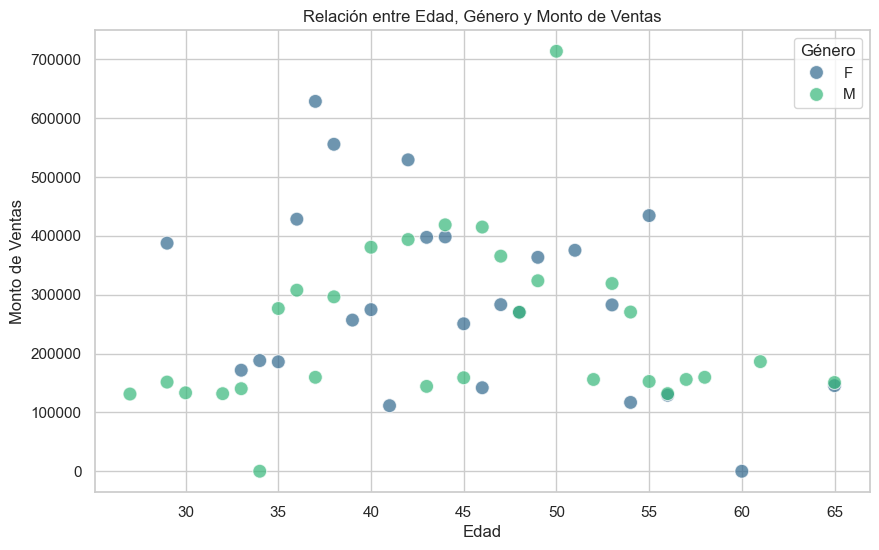

Matriz de Correlación:
                   age  gender_num  quantity_X_price
age               1.00       -0.01             -0.09
gender_num       -0.01        1.00             -0.17
quantity_X_price -0.09       -0.17              1.00


In [49]:
# Configurar el estilo de los gráficos
sns.set(style="whitegrid")

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_sales_prices_employee_final, x='age', y='quantity_X_price', hue='gender', palette='viridis', alpha=0.7, s=100)
plt.title('Relación entre Edad, Género y Monto de Ventas')
plt.xlabel('Edad')
plt.ylabel('Monto de Ventas')
plt.legend(title='Género')
plt.show()

# Agregar la columna gender_num
df_sales_prices_employee_final['gender_num'] = df_sales_prices_employee_final['gender'].apply(lambda x: 1 if x == 'M' else 0)

correlation_matrix = df_sales_prices_employee_final[['age', 'gender_num', 'quantity_X_price']].corr()
print("Matriz de Correlación:")
print(correlation_matrix)

# Requisito 7
### También desea saber cuáles son los 5 vendedores más prometedores.

In [461]:
# Agrupar las ventas por empleado (vendedor) y calcular el total de ventas
df_sales_by_employee = df_sales_prices_employee.groupby('employee_id').agg(
    total_sales_value=('quantity_X_price', 'sum')  # Sumar el valor total de ventas
).reset_index()

# Ordenar por el valor total de ventas de mayor a menor
df_sales_by_employee = df_sales_by_employee.sort_values(by='total_sales_value', ascending=False)

# Seleccionar los 5 empleados más prometedores (con mayores ingresos generados)
top_5_employees = df_sales_by_employee.head(5)

# Mostrar los resultados
print("Los 5 vendedores más prometedores:")
print(top_5_employees)


Los 5 vendedores más prometedores:
    employee_id  total_sales_value
0            59         239,732.74
2            61         230,116.53
1            60         188,048.01
56          296         187,189.38
40          233         186,296.06


# Requisito 8: 
### Relación entre antigüedad del empleado y ventas


Relación entre antigüedad y cantidad de productos vendidos:
            full_name  total_quantity_sold  seniority
5      Anderson, Lori               219585          7
17       Borden, Mary               210711          8
37   Everson, Michael               171948          7
101      Willson, Sue               170946          6
69       Pearl, Keith               169509          7
31       Cramer, Mary               168063          5
79   Roundtree, Sarah               166743          8
3      Albright, Anna               165477          5
83      Stedman, Cian               164805          7
100    White, Cynthia               160626          6


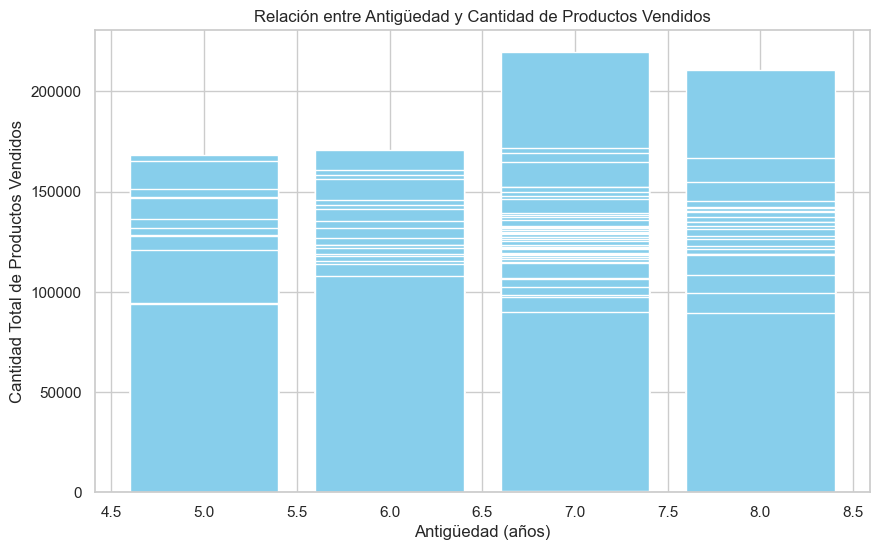

In [54]:
# Asegúrate de que la columna 'employment_date' esté en formato de fecha
df_sales_prices_employee['employment_date'] = pd.to_datetime(df_sales_prices_employee['employment_date'], errors='coerce')

# Fecha de referencia (31 de diciembre de 2009)
reference_date = datetime(2009, 12, 31)

# Función para calcular la antigüedad
def calculate_seniority(employment_date):
    if pd.isnull(employment_date):
        return 0  # Si no hay fecha de empleo, consideramos antigüedad 0
    return reference_date.year - employment_date.year - ((reference_date.month, reference_date.day) < (employment_date.month, employment_date.day))

# Aplicar la función para calcular la antigüedad
df_sales_prices_employee['seniority'] = df_sales_prices_employee['employment_date'].apply(calculate_seniority)


# Agrupar las ventas por empleado (nombre completo) y calcular la cantidad total de productos vendidos
df_sales_by_employee = df_sales_prices_employee.groupby('full_name').agg(
    total_quantity_sold=('quantity', 'sum'),  # Sumar la cantidad total de productos vendidos
    seniority=('seniority', 'first')  # Tomar la antigüedad del empleado
).reset_index()

# Ordenar los resultados por antigüedad (de mayor a menor) para observar la relación
df_sales_by_employee_sorted = df_sales_by_employee.sort_values(by='total_quantity_sold', ascending=False)

# Mostrar los resultados ordenados por antigüedad
print("Relación entre antigüedad y cantidad de productos vendidos:")
print(df_sales_by_employee_sorted.head(10))  # Muestra los primeros 10 registros

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(df_sales_by_employee_sorted['seniority'], df_sales_by_employee_sorted['total_quantity_sold'], color='skyblue')
plt.title('Relación entre Antigüedad y Cantidad de Productos Vendidos')
plt.xlabel('Antigüedad (años)')
plt.ylabel('Cantidad Total de Productos Vendidos')
plt.grid(True)
plt.show()

# Requisito 9: 
### Análisis de la popularidad de las bebidas diet Verificaremos si las ventas de bebidas diet han disminuido a lo largo del tiempo.

Ventas de productos que contienen 'Diet' en el detalle a lo largo del tiempo:
  year_month  total_sales
0    2009-01   844,415.59
1    2009-02   772,318.74
2    2009-03   451,733.91
3    2009-04   709,023.11
4    2009-05   656,506.18
5    2009-06   796,078.54
6    2009-07    57,223.43
7    2009-08   528,843.34


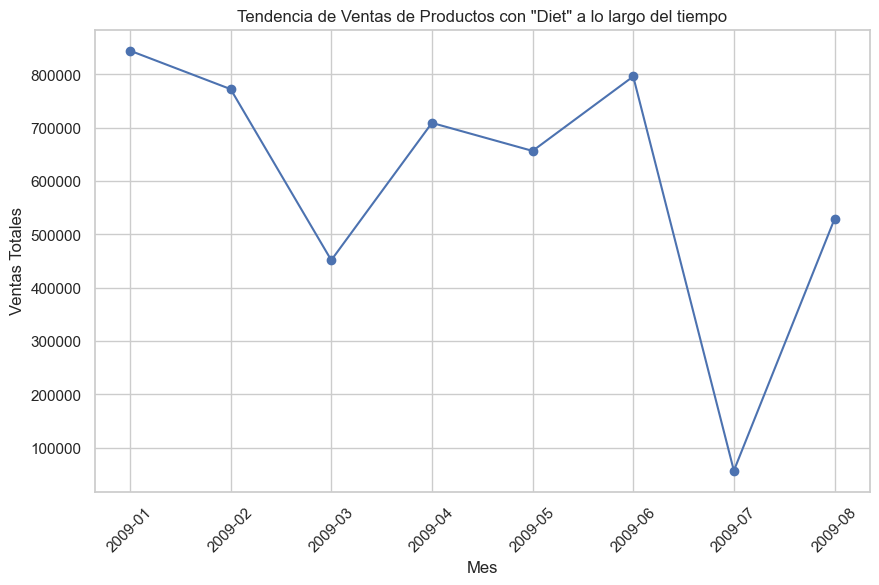

In [55]:
# Hacer el merge entre la tabla de ventas y la tabla de productos basado en 'product_id'
df_sales_with_products = df_sales_prices_employee.merge(df_products, how='inner', on='product_id')

# Filtrar las ventas de productos que contienen la palabra 'Diet' en la columna 'detail'
df_diet_sales = df_sales_with_products[df_sales_with_products['detail'].str.contains(r'\bDiet\b', case=False, na=False)].copy()

# Calcular el valor total de ventas (cantidad * precio) utilizando .loc para evitar el SettingWithCopyWarning
df_diet_sales.loc[:, 'quantity_X_price'] = df_diet_sales['quantity'] * df_diet_sales['price']

# Crear una columna para agrupar por año y mes
df_diet_sales.loc[:, 'year_month'] = df_diet_sales['date'].dt.to_period('M')

# Agrupar las ventas por año y mes y sumar el valor total de ventas
df_diet_sales_sum = df_diet_sales.groupby('year_month').agg(
    total_sales=('quantity_X_price', 'sum')  # Sumar el valor total de ventas de bebidas diet
).reset_index()

# Mostrar los resultados ordenados por año y mes
print("Ventas de productos que contienen 'Diet' en el detalle a lo largo del tiempo:")
print(df_diet_sales_sum)


# Visualizar la tendencia de ventas de productos con 'Diet' a lo largo del tiempo
plt.figure(figsize=(10, 6))
plt.plot(df_diet_sales_sum['year_month'].astype(str), df_diet_sales_sum['total_sales'], marker='o', linestyle='-', color='b')
plt.title('Tendencia de Ventas de Productos con "Diet" a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Ventas Totales')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


# Requisito 10: Consumo de bebidas en lata
### Verificamos si las ventas de bebidas en lata están disminuyendo a lo largo del tiempo.

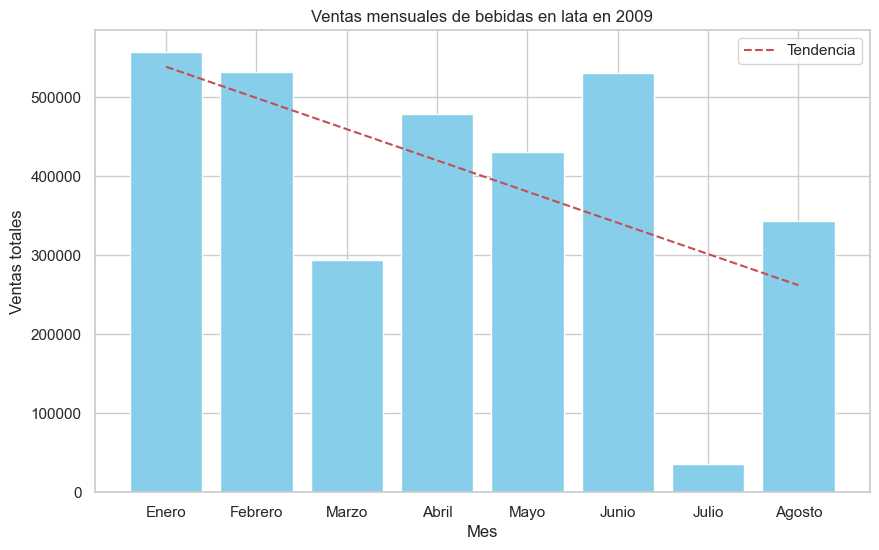

Hay una tendencia negativa en las ventas mensuales de bebidas en lata en 2009.


In [56]:
# Hacer el merge entre la tabla de ventas y la tabla de productos basado en 'product_id'
df_sales_with_products = df_sales_prices_employee.merge(df_products, how='inner', on='product_id')

# Filtrar las ventas de bebidas que están en latas ('Can') en el campo 'package'
can_sales = df_sales_with_products[df_sales_with_products['package'].str.contains('Can', case=False, na=False)].copy()

# Calcular el valor total de ventas (cantidad * precio)
can_sales['total_sales'] = can_sales['quantity'] * can_sales['price']

# Filtrar por un año específico (ejemplo: 2009)
year = 2009
can_sales['year'] = can_sales['date'].dt.year
can_sales_year = can_sales[can_sales['year'] == year].copy()

# Agrupar las ventas por mes y sumar el total vendido
can_sales_year['month'] = can_sales_year['date'].dt.month
can_sales_by_month = can_sales_year.groupby('month')[['total_sales']].sum().reset_index()

# Generar el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(can_sales_by_month['month'], can_sales_by_month['total_sales'], color='skyblue')

# Ajustar etiquetas y títulos
plt.title(f'Ventas mensuales de bebidas en lata en {year}')
plt.xlabel('Mes')
plt.ylabel('Ventas totales')
plt.xticks(np.arange(1, 13), ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'])

# Calcular la línea de tendencia (regresión lineal)
z = np.polyfit(can_sales_by_month['month'], can_sales_by_month['total_sales'], 1)
p = np.poly1d(z)
plt.plot(can_sales_by_month['month'], p(can_sales_by_month['month']), "r--", label="Tendencia")

plt.legend()
plt.grid(True)
plt.show()

# Mostrar la tendencia calculada
if z[0] > 0:
    print(f"Hay una tendencia positiva en las ventas mensuales de bebidas en lata en {year}.")
elif z[0] < 0:
    print(f"Hay una tendencia negativa en las ventas mensuales de bebidas en lata en {year}.")
else:
    print(f"No se detecta una tendencia significativa en las ventas")


# Requisito 11: Determinar qué productos discontinuar

   product_id     detail year_month  total_quantity_sold  total_sales_value
0           1  Kool Cola    2009-01                54894          40,438.58
1           1  Kool Cola    2009-02                50067          36,882.69
2           1  Kool Cola    2009-03                26850          19,779.50
3           1  Kool Cola    2009-04                45507          33,523.49
4           1  Kool Cola    2009-05                41430          30,520.10


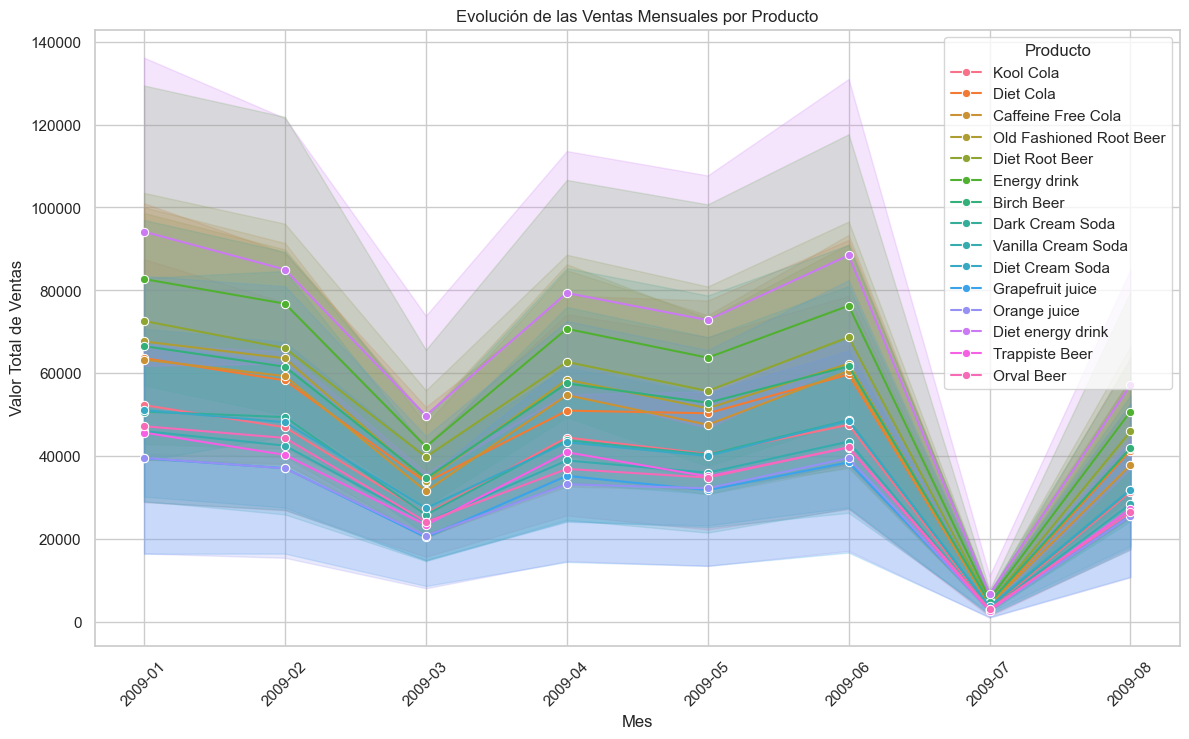

In [65]:

# Hacer el merge entre la tabla de ventas y la tabla de productos basado en 'product_id'
df_sales_with_products = df_sales_prices_employee.merge(df_products, how='inner', on='product_id')

# Calcular el valor total de ventas (cantidad * precio) para cada producto
df_sales_with_products['total_sales_value'] = df_sales_with_products['quantity'] * df_sales_with_products['price']

# Asegúrate de que la columna 'date' esté en formato de fecha
df_sales_with_products['date'] = pd.to_datetime(df_sales_with_products['date'], errors='coerce')

# Crear una columna para el año y el mes
df_sales_with_products['year_month'] = df_sales_with_products['date'].dt.to_period('M').astype(str)

# Agrupar las ventas por producto y por mes
product_sales_monthly = df_sales_with_products.groupby(['product_id', 'detail', 'year_month']).agg(
    total_quantity_sold=('quantity', 'sum'),
    total_sales_value=('total_sales_value', 'sum')
).reset_index()

# Mostrar los primeros registros para verificar
print(product_sales_monthly.head(5))



# Crear el gráfico de líneas para todos los productos
plt.figure(figsize=(14, 8))
sns.lineplot(data=product_sales_monthly, x='year_month', y='total_sales_value', hue='detail', marker='o')

plt.title('Evolución de las Ventas Mensuales por Producto')
plt.xlabel('Mes')
plt.ylabel('Valor Total de Ventas')
plt.legend(title='Producto')
plt.grid(True)
plt.xticks(rotation=45)  # Rotar las etiquetas del eje x para mejor legibilidad
plt.show()

# Requisito 12: Clientes más valiosos


Top 5 clientes más valiosos para la empresa:
     CUSTOMER_ID           FULL_NAME  total_sales_value  total_quantity_sold
232         2233     Buskirk, Deanna          70,079.01                63270
16          2017    Hernandez, Irene          69,871.51                63585
34          2035         Suess, Gary          69,273.33                64323
65          2066  Altamirano, Sandra          66,626.16                60354
225         2226       Lundahl, Judy          65,813.24                59985


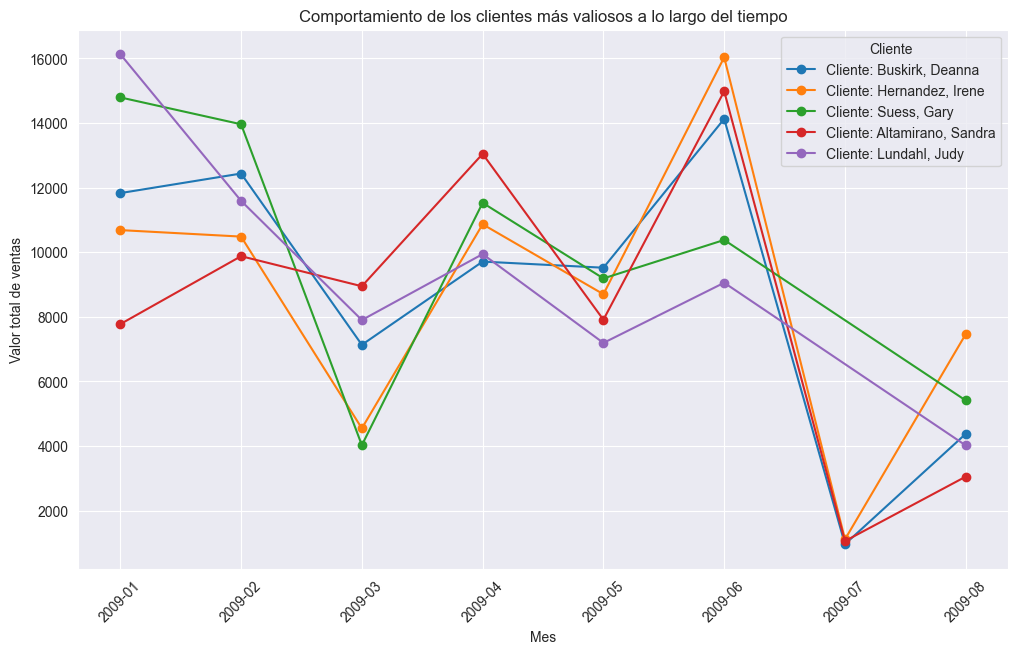

In [466]:
# Hacer el merge entre la tabla de ventas, productos y clientes usando 'CUSTOMER_ID'
df_sales_with_products = df_sales_prices_employee.merge(df_products, how='inner', on='product_id')
df_sales_with_customer = df_sales_with_products.merge(df_wholesale, how='inner', left_on='customer_id', right_on='CUSTOMER_ID')

# Calcular el valor total de ventas (cantidad * precio)
df_sales_with_customer['total_sales_value'] = df_sales_with_customer['quantity'] * df_sales_with_customer['price']

# Agrupar las ventas por cliente para calcular el valor total generado por cada cliente
customer_sales_summary = df_sales_with_customer.groupby(['CUSTOMER_ID', 'FULL_NAME']).agg(
    total_sales_value=('total_sales_value', 'sum'),  # Sumar el valor total generado por cada cliente
    total_quantity_sold=('quantity', 'sum')  # Sumar la cantidad total de productos comprados por cada cliente
).reset_index()

# Ordenar los clientes por el valor total de ventas en orden descendente
most_valuable_customers = customer_sales_summary.sort_values(by='total_sales_value', ascending=False)

# Mostrar los 5 clientes más valiosos
top_5_customers = most_valuable_customers.head(5)
print("Top 5 clientes más valiosos para la empresa:")
print(top_5_customers)

# Comportamiento a lo largo del tiempo
# Analizar cómo evolucionaron las ventas de estos clientes mes a mes

# Filtrar las ventas de los clientes más valiosos
top_5_customer_names = top_5_customers['FULL_NAME'].tolist()
sales_top_customers = df_sales_with_customer[df_sales_with_customer['FULL_NAME'].isin(top_5_customer_names)].copy()

# Extraer el año y mes de la columna de fechas
sales_top_customers['year_month'] = sales_top_customers['date'].dt.to_period('M')

# Agrupar las ventas por cliente y por mes para ver el comportamiento a lo largo del tiempo
customer_behavior_over_time = sales_top_customers.groupby(['FULL_NAME', 'year_month']).agg(
    total_sales_value=('total_sales_value', 'sum')
).reset_index()

# Generar gráficos para los 5 clientes más valiosos
plt.figure(figsize=(12, 7))

for customer_name in top_5_customer_names:
    customer_data = customer_behavior_over_time[customer_behavior_over_time['FULL_NAME'] == customer_name]
    plt.plot(customer_data['year_month'].astype(str), customer_data['total_sales_value'], marker='o', linestyle='-', label=f'Cliente: {customer_name}')

# Ajustar etiquetas y títulos
plt.title('Comportamiento de los clientes más valiosos a lo largo del tiempo')
plt.xlabel('Mes')
plt.ylabel('Valor total de ventas')
plt.xticks(rotation=45)
plt.legend(title="Cliente")
plt.grid(True)
plt.show()
